# Simple recommender + Content based recommender

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style("darkgrid")
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, accuracy, evaluate
from surprise.model_selection import cross_validate, KFold
from surprise.model_selection import train_test_split
from plotly.offline import init_notebook_mode, plot, iplot


In [2]:
df = pd.read_csv('./final dataset.csv')

In [3]:
df.drop(['Unnamed: 0', 'titleType'], axis=1, inplace=True)

In [4]:
df.shape

(990277, 13)

In [5]:
df.head()

,Cust_Id,Rating,Date,Movie_Id,Year,Title,tconst,isAdult,runtimeMinutes,genres,actor,actress,director
0,2632461,3.0,2005-07-22,3,1997.0,Character,tt0119448,0.0,122,"Crime,Drama,Mystery",Jan Decleir,Betty Schuurman,Mike van Diem
1,931626,2.0,2004-07-08,3,1997.0,Character,tt0119448,0.0,122,"Crime,Drama,Mystery",Jan Decleir,Betty Schuurman,Mike van Diem
2,1628475,4.0,2005-11-14,3,1997.0,Character,tt0119448,0.0,122,"Crime,Drama,Mystery",Jan Decleir,Betty Schuurman,Mike van Diem
3,2266857,3.0,2003-06-13,3,1997.0,Character,tt0119448,0.0,122,"Crime,Drama,Mystery",Jan Decleir,Betty Schuurman,Mike van Diem
4,402377,4.0,2005-04-10,3,1997.0,Character,tt0119448,0.0,122,"Crime,Drama,Mystery",Jan Decleir,Betty Schuurman,Mike van Diem


In [6]:
df.loc[df['Title'] == 'Bruce Almighty']

,Cust_Id,Rating,Date,Movie_Id,Year,Title,tconst,isAdult,runtimeMinutes,genres,actor,actress,director
829490,506696,4.0,2005-07-12,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829491,422507,3.0,2005-07-13,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829492,1170033,4.0,2003-12-15,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829493,1276913,5.0,2004-04-13,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829494,183907,3.0,2005-03-15,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829495,1300046,4.0,2005-08-07,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829496,1565388,4.0,2004-02-21,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829497,850738,4.0,2005-08-17,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829498,159007,4.0,2004-03-08,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac
829499,1768932,4.0,2004-04-05,3860,2003.0,Bruce Almighty,tt0315327,0.0,101,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,Tom Shadyac


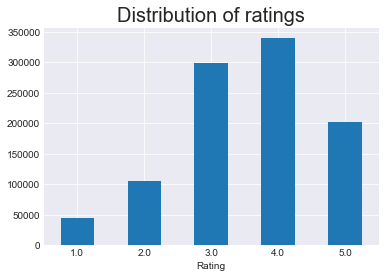

In [7]:
p = df.groupby('Rating')['Rating'].agg(['count'])


# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count


ax = p.plot(kind = 'bar', legend = False)
plt.title(('Distribution of ratings'), fontsize=20)

for tick in ax.get_xticklabels():
    tick.set_rotation(360)

In [8]:
df = df.rename({'tconst':'imdb_id'}, axis=1)

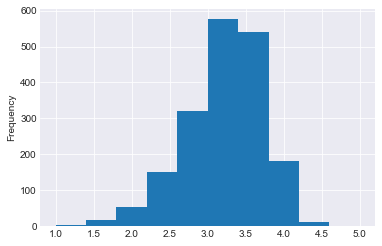

In [9]:
# take top movies?
df.groupby('Title')['Rating'].mean().sort_values(ascending = False).plot(kind='hist')

In [10]:
df.isnull().sum()

Cust_Id                0
Rating                 0
Date                   0
Movie_Id               0
Year                   0
Title                  0
imdb_id                0
isAdult                0
runtimeMinutes         0
genres                 0
actor              14176
actress           126882
director           32830
dtype: int64

In [11]:
metadata = pd.read_csv('./movies_metadata.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [12]:
df = df.merge(metadata[['imdb_id','overview']], on='imdb_id')

# Simple recommender

The Simple Recommender offers generalized recommendations to every user based on movie popularity and (sometimes) genre.

The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience.

This model does not give personalized recommendations based on the user.

What we are actually doing:

The implementation of this model is extremely trivial.
All we have to do is sort our movies based on ratings and popularity and display the top movies of our list.
As an added step, we can pass in a genre argument to get the top movies of a particular genre.

In [13]:
""" v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole report"""



# this is V
vote_counts = df.groupby('Title')['Rating'].count().to_frame()

# this is R
vote_averages = df.groupby('Title')['Rating'].mean().to_frame()

# this is C
C = vote_averages.mean()
C

Rating    3.266071
dtype: float64

In [14]:
m = vote_counts.quantile(0.90)
m

Rating    1645.6
Name: 0.9, dtype: float64

In [15]:
counts = df.groupby('Title')['Rating'].count().to_frame()

In [16]:
counts.head()

,Rating
Title,
10,261
10 Things I Hate About You,2520
13 Ghosts,395
13 Moons,26
1984,251


In [17]:
counts.columns = ['counts']

In [18]:
counts['average'] = df.groupby('Title')['Rating'].count()

In [19]:
# get those more than m
qualified = counts[counts['counts'] > int(m)]

In [20]:
qualified = qualified.merge(df[['Title','Year', 'genres', 'actor', 'actress','overview']], on='Title')


In [21]:
qualified.head()

,Title,counts,average,Year,genres,actor,actress,overview
0,10 Things I Hate About You,2520,2520,1999.0,"Comedy,Drama,Romance",Joseph Gordon-Levitt,Larisa Oleynik,"Bianca, a tenth grader, has never gone on a da..."
1,10 Things I Hate About You,2520,2520,1999.0,"Comedy,Drama,Romance",Joseph Gordon-Levitt,Larisa Oleynik,"Bianca, a tenth grader, has never gone on a da..."
2,10 Things I Hate About You,2520,2520,1999.0,"Comedy,Drama,Romance",Joseph Gordon-Levitt,Larisa Oleynik,"Bianca, a tenth grader, has never gone on a da..."
3,10 Things I Hate About You,2520,2520,1999.0,"Comedy,Drama,Romance",Joseph Gordon-Levitt,Larisa Oleynik,"Bianca, a tenth grader, has never gone on a da..."
4,10 Things I Hate About You,2520,2520,1999.0,"Comedy,Drama,Romance",Joseph Gordon-Levitt,Larisa Oleynik,"Bianca, a tenth grader, has never gone on a da..."


In [22]:
qualified.shape

(615870, 8)

In [23]:
qualified = qualified.drop_duplicates()

In [24]:
def weighted_rating(x):
    v = x['counts']
    R = x['average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [25]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)


In [26]:
qualified = qualified.sort_values('wr', ascending=False).head(250)


In [27]:
qualified.head(15)


,Title,counts,average,Year,genres,actor,actress,overview,wr
332541,Pirates of the Caribbean: The Curse of the Bla...,10307,10307,2003.0,"Action,Adventure,Fantasy",Johnny Depp,Keira Knightley,"Jack Sparrow, a freewheeling 17th-century pira...",8888.411195
602162,What Women Want,8572,8572,2000.0,"Comedy,Fantasy,Romance",Alan Alda,Helen Hunt,Advertising executive Nick Marshall is as cock...,7191.958840
102476,Bruce Almighty,8519,8519,2003.0,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,"Bruce Nolan toils as a ""human interest"" televi...",7140.343511
487260,The Italian Job,8356,8356,2003.0,"Action,Crime,Thriller",Donald Sutherland,Charlize Theron,Charlie Croker pulled off the crime of a lifet...,6981.693994
403615,Shrek 2,8196,8196,2004.0,"Adventure,Animation,Comedy",Eddie Murphy,Julie Andrews,"Shrek, Fiona and Donkey set off to Far, Far Aw...",6826.104561
41648,American Beauty,8195,8195,1999.0,Drama,Kevin Spacey,Thora Birch,"Lester Burnham, a depressed suburban father in...",6825.132578
554988,The Sixth Sense,8152,8152,1999.0,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,A psychological thriller about an eight year o...,6783.342721
4401,50 First Dates,7733,7733,2004.0,"Comedy,Drama,Romance",Sean Astin,Drew Barrymore,Henry is a player skilled at seducing women. B...,6376.715464
577795,The Wedding Planner,7417,7417,2001.0,"Comedy,Romance",Matthew McConaughey,Jennifer Lopez,"Mary Fiore, San Francisco's premiere wedding p...",6070.803483
465278,The Bourne Supremacy,7384,7384,2004.0,"Action,Mystery,Thriller",Brian Cox,Joan Allen,When a CIA operation to purchase classified Ru...,6038.897697


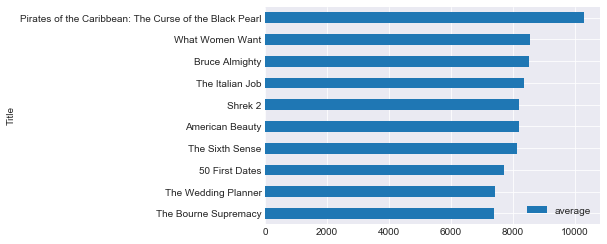

In [28]:
qualified[['Title','average']].head(10).set_index('Title').sort_values(by='average', ascending=True).plot.barh()

In [29]:
dummies = qualified['genres'].str.get_dummies(sep=',')


In [30]:
dummies.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
332541,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
602162,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
102476,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
487260,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
403615,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
dummyt = dummies.T
# then sum
# then plot

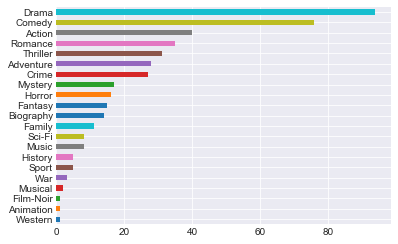

In [32]:
dummyt.sum(axis=1).sort_values(ascending=True).plot.barh()

In [33]:
topmovies = qualified.merge(dummies, on=dummies.index).set_index(dummies.index)


In [34]:
topmovies.head()

,key_0,Title,counts,average,Year,genres,actor,actress,overview,wr,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
332541,332541,Pirates of the Caribbean: The Curse of the Bla...,10307,10307,2003.0,"Action,Adventure,Fantasy",Johnny Depp,Keira Knightley,"Jack Sparrow, a freewheeling 17th-century pira...",8888.411195,...,0,0,0,0,0,0,0,0,0,0
602162,602162,What Women Want,8572,8572,2000.0,"Comedy,Fantasy,Romance",Alan Alda,Helen Hunt,Advertising executive Nick Marshall is as cock...,7191.958840,...,0,0,0,0,1,0,0,0,0,0
102476,102476,Bruce Almighty,8519,8519,2003.0,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,"Bruce Nolan toils as a ""human interest"" televi...",7140.343511,...,0,0,0,0,0,0,0,0,0,0
487260,487260,The Italian Job,8356,8356,2003.0,"Action,Crime,Thriller",Donald Sutherland,Charlize Theron,Charlie Croker pulled off the crime of a lifet...,6981.693994,...,0,0,0,0,0,0,0,1,0,0
403615,403615,Shrek 2,8196,8196,2004.0,"Adventure,Animation,Comedy",Eddie Murphy,Julie Andrews,"Shrek, Fiona and Donkey set off to Far, Far Aw...",6826.104561,...,0,0,0,0,0,0,0,0,0,0


In [35]:
topmovies.drop('key_0',axis=1,inplace=True)

In [36]:
def build_chart(genre):    
    return topmovies[topmovies[genre] == 1].head(15)

In [37]:
build_chart('Comedy')

,Title,counts,average,Year,genres,actor,actress,overview,wr,Action,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
602162,What Women Want,8572,8572,2000.0,"Comedy,Fantasy,Romance",Alan Alda,Helen Hunt,Advertising executive Nick Marshall is as cock...,7191.958840,0,...,0,0,0,0,1,0,0,0,0,0
102476,Bruce Almighty,8519,8519,2003.0,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,"Bruce Nolan toils as a ""human interest"" televi...",7140.343511,0,...,0,0,0,0,0,0,0,0,0,0
403615,Shrek 2,8196,8196,2004.0,"Adventure,Animation,Comedy",Eddie Murphy,Julie Andrews,"Shrek, Fiona and Donkey set off to Far, Far Aw...",6826.104561,0,...,0,0,0,0,0,0,0,0,0,0
4401,50 First Dates,7733,7733,2004.0,"Comedy,Drama,Romance",Sean Astin,Drew Barrymore,Henry is a player skilled at seducing women. B...,6376.715464,0,...,0,0,0,0,1,0,0,0,0,0
577795,The Wedding Planner,7417,7417,2001.0,"Comedy,Romance",Matthew McConaughey,Jennifer Lopez,"Mary Fiore, San Francisco's premiere wedding p...",6070.803483,0,...,0,0,0,0,1,0,0,0,0,0
293252,Men in Black II,7250,7250,2002.0,"Action,Adventure,Comedy",Rip Torn,Lara Flynn Boyle,"Kay and Jay reunite to provide our best, last ...",5909.424282,1,...,0,0,0,0,0,0,0,0,0,0
320736,Patch Adams,6536,6536,1998.0,"Biography,Comedy,Drama",Robin Williams,Monica Potter,"Meet Patch Adams, a doctor who doesn't look, a...",5222.043445,0,...,0,0,0,0,0,0,0,0,0,0
439171,Something's Gotta Give,6287,6287,2003.0,"Comedy,Drama,Romance",Jack Nicholson,Diane Keaton,Harry Sanborn is an aged music industry exec w...,4983.453552,0,...,0,0,0,0,1,0,0,0,0,0
411811,Sideways,6241,6241,2004.0,"Comedy,Drama,Romance",Thomas Haden Church,Virginia Madsen,Two middle-aged men embark on a spiritual jour...,4939.448640,0,...,0,0,0,0,1,0,0,0,0,0
430336,Sleepless in Seattle,6206,6206,1993.0,"Comedy,Drama,Romance",Tom Hanks,Meg Ryan,A young boy who tries to set his dad up on a d...,4905.982303,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
build_chart('Romance')

In [ ]:
# work with the qualified subset

In [38]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(qualified['overview'])

In [39]:
tfidf_matrix.shape


(167, 7092)

In [40]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [41]:
cosine_sim[0]


array([1.        , 0.        , 0.00513518, 0.        , 0.        ,
       0.02341582, 0.0080226 , 0.01318611, 0.        , 0.02317991,
       0.00923049, 0.01023415, 0.01665399, 0.01883441, 0.0340997 ,
       0.00700495, 0.        , 0.        , 0.00490522, 0.        ,
       0.        , 0.        , 0.04402802, 0.        , 0.        ,
       0.01264113, 0.0102911 , 0.        , 0.        , 0.01061117,
       0.00501851, 0.        , 0.01026133, 0.00775568, 0.01268875,
       0.        , 0.        , 0.        , 0.00580971, 0.        ,
       0.        , 0.00790456, 0.01182823, 0.        , 0.00559597,
       0.        , 0.00823994, 0.01818822, 0.        , 0.        ,
       0.        , 0.        , 0.02413874, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00571212, 0.        ,
       0.        , 0.01976899, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01402904, 0.        , 0.0120754 ,
       0.01468944, 0.00634845, 0.        , 0.        , 0.00574

In [42]:
qualified = qualified.reset_index()
titles = qualified['Title']
indices = pd.Series(qualified.index, index=qualified['Title'])

In [43]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [44]:
get_recommendations('Bruce Almighty').head(10)


91            Batman Begins
75               The Others
149              Barbershop
103              Moonstruck
71              Serendipity
30     Being John Malkovich
7            50 First Dates
34                    Speed
63          Lethal Weapon 3
136         The Deer Hunter
Name: Title, dtype: object

In [ ]:
get_recommendations('Men in Black II').head(10)


In [ ]:
# use cast members, genres,AS AN IMPROVEMENT

In [45]:
cast = qualified.copy().set_index('index')

In [46]:
cast.head()

,Title,counts,average,Year,genres,actor,actress,overview,wr
index,,,,,,,,,
332541,Pirates of the Caribbean: The Curse of the Bla...,10307,10307,2003.0,"Action,Adventure,Fantasy",Johnny Depp,Keira Knightley,"Jack Sparrow, a freewheeling 17th-century pira...",8888.411195
602162,What Women Want,8572,8572,2000.0,"Comedy,Fantasy,Romance",Alan Alda,Helen Hunt,Advertising executive Nick Marshall is as cock...,7191.958840
102476,Bruce Almighty,8519,8519,2003.0,"Comedy,Drama,Fantasy",Morgan Freeman,Jennifer Aniston,"Bruce Nolan toils as a ""human interest"" televi...",7140.343511
487260,The Italian Job,8356,8356,2003.0,"Action,Crime,Thriller",Donald Sutherland,Charlize Theron,Charlie Croker pulled off the crime of a lifet...,6981.693994
403615,Shrek 2,8196,8196,2004.0,"Adventure,Animation,Comedy",Eddie Murphy,Julie Andrews,"Shrek, Fiona and Donkey set off to Far, Far Aw...",6826.104561


In [47]:
cast['genres'] = cast['genres'].str.replace(',', ' ')

In [48]:
cast.head()

,Title,counts,average,Year,genres,actor,actress,overview,wr
index,,,,,,,,,
332541,Pirates of the Caribbean: The Curse of the Bla...,10307,10307,2003.0,Action Adventure Fantasy,Johnny Depp,Keira Knightley,"Jack Sparrow, a freewheeling 17th-century pira...",8888.411195
602162,What Women Want,8572,8572,2000.0,Comedy Fantasy Romance,Alan Alda,Helen Hunt,Advertising executive Nick Marshall is as cock...,7191.958840
102476,Bruce Almighty,8519,8519,2003.0,Comedy Drama Fantasy,Morgan Freeman,Jennifer Aniston,"Bruce Nolan toils as a ""human interest"" televi...",7140.343511
487260,The Italian Job,8356,8356,2003.0,Action Crime Thriller,Donald Sutherland,Charlize Theron,Charlie Croker pulled off the crime of a lifet...,6981.693994
403615,Shrek 2,8196,8196,2004.0,Adventure Animation Comedy,Eddie Murphy,Julie Andrews,"Shrek, Fiona and Donkey set off to Far, Far Aw...",6826.104561


In [49]:
cast.isnull().sum()

Title        0
counts       0
average      0
Year         0
genres       0
actor        2
actress     23
overview     0
wr           0
dtype: int64

In [50]:
cast = cast.dropna()

In [51]:
cast.isnull().sum().sum()

0

In [52]:
cast['cast'] = cast['actress'] + ' ' + cast['actor'] + ' ' + cast['genres']


In [53]:
cast.head()

,Title,counts,average,Year,genres,actor,actress,overview,wr,cast
index,,,,,,,,,,
332541,Pirates of the Caribbean: The Curse of the Bla...,10307,10307,2003.0,Action Adventure Fantasy,Johnny Depp,Keira Knightley,"Jack Sparrow, a freewheeling 17th-century pira...",8888.411195,Keira Knightley Johnny Depp Action Adventure F...
602162,What Women Want,8572,8572,2000.0,Comedy Fantasy Romance,Alan Alda,Helen Hunt,Advertising executive Nick Marshall is as cock...,7191.958840,Helen Hunt Alan Alda Comedy Fantasy Romance
102476,Bruce Almighty,8519,8519,2003.0,Comedy Drama Fantasy,Morgan Freeman,Jennifer Aniston,"Bruce Nolan toils as a ""human interest"" televi...",7140.343511,Jennifer Aniston Morgan Freeman Comedy Drama F...
487260,The Italian Job,8356,8356,2003.0,Action Crime Thriller,Donald Sutherland,Charlize Theron,Charlie Croker pulled off the crime of a lifet...,6981.693994,Charlize Theron Donald Sutherland Action Crime...
403615,Shrek 2,8196,8196,2004.0,Adventure Animation Comedy,Eddie Murphy,Julie Andrews,"Shrek, Fiona and Donkey set off to Far, Far Aw...",6826.104561,Julie Andrews Eddie Murphy Adventure Animation...


In [54]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(cast['cast'])

In [55]:
count_matrix.shape

(142, 1049)

In [56]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)


In [57]:
cast = cast.reset_index()
titles = cast['Title']
indices = pd.Series(cast.index, index=cast['Title'])

In [58]:
get_recommendations('Bruce Almighty').head(10)


26                   Being John Malkovich
54                         The Family Man
30                       Along Came Polly
95          Robin Hood: Prince of Thieves
127                            Barbershop
37                          About Schmidt
45                              Liar Liar
76     The Life Aquatic with Steve Zissou
89                             Moonstruck
131                           Wonder Boys
Name: Title, dtype: object

In [102]:
cast[cast['Title'] == 'Bruce Almighty']

,index,Title,counts,average,Year,genres,actor,actress,overview,wr,cast
2,102476,Bruce Almighty,8519,8519,2003.0,Comedy Drama Fantasy,Morgan Freeman,Jennifer Aniston,"Bruce Nolan toils as a ""human interest"" televi...",7140.343511,Jennifer Aniston Morgan Freeman Comedy Drama F...


In [104]:
cast.loc[2, 'overview']

'Bruce Nolan toils as a "human interest" television reporter in Buffalo, N.Y. Despite his high ratings and the love of his beautiful girlfriend, Grace, Bruce remains unfulfilled. At the end of the worst day in his life, he angrily ridicules God -- and the Almighty responds, endowing Bruce with all of His divine powers.'

# Collaborative filtering
personalize! 

In [74]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 716.0
Customer minimum times of review: 63.0


In [67]:
reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)


# define a cross-validation iterator


kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9164
RMSE: 0.9201
RMSE: 0.9193


In [71]:
movies = pd.read_csv('./datasets/movie_titles.csv', encoding='latin1', usecols = [0,1,2], names = ['Movie_Id','Year', 'Title']).set_index('Movie_Id')


In [77]:
df_1276913 = df[(df['Cust_Id'] == 1276913) & (df['Rating'] == 5)]
df_1276913

,Cust_Id,Rating,Date,Movie_Id,Year,imdb_id,isAdult,runtimeMinutes,genres,actor,actress,director,overview
Title,,,,,,,,,,,,,
Congo,1276913,5.0,2003-11-22,77,1995.0,tt0112715,0.0,109,"Action,Adventure,Mystery",Tim Curry,Laura Linney,Frank Marshall,Eight people embark on an expedition into the ...
Jingle All the Way,1276913,5.0,2002-06-20,78,1996.0,tt0116705,0.0,89,"Comedy,Family",Arnold Schwarzenegger,Rita Wilson,Brian Levant,"Meet Howard Langston, a salesman for a mattres..."
The Great Race,1276913,5.0,2005-06-06,104,1965.0,tt0059243,0.0,160,"Action,Adventure,Comedy",Jack Lemmon,Natalie Wood,Blake Edwards,"Professional daredevil and white-suited hero, ..."
Rambo: First Blood Part II,1276913,5.0,2005-01-05,118,1985.0,tt0089880,0.0,96,"Action,Adventure,Thriller",Richard Crenna,NaN,George P. Cosmatos,John Rambo is released from prison by the gove...
Airplane II: The Sequel,1276913,5.0,2003-08-05,189,1982.0,tt0083530,0.0,85,"Comedy,Sci-Fi",Lloyd Bridges,Julie Hagerty,Ken Finkleman,A faulty computer causes a passenger space shu...
Herbie Rides Again,1276913,5.0,2005-07-03,262,1974.0,tt0071607,0.0,88,"Comedy,Family,Fantasy",John McIntire,Helen Hayes,Robert Stevenson,The living Volkswagen Beetle helps a old lady ...
The Legend,1276913,5.0,2005-05-01,281,1993.0,tt0106936,0.0,100,"Action,Comedy,History",Jet Li,Josephine Siao,Corey Yuen,This Hong Kong martial-arts extravaganza tells...
The Avengers,1276913,5.0,2004-03-29,289,1998.0,tt0118661,0.0,89,"Action,Adventure,Sci-Fi",Patrick Macnee,Uma Thurman,Jeremiah S. Chechik,"British Ministry agent John Steed, under direc..."
Jack,1276913,5.0,2005-07-03,305,1996.0,tt0116669,0.0,113,"Comedy,Drama,Fantasy",Robin Williams,Diane Lane,Francis Ford Coppola,Jack Powell suffers from an affliction that ma...


In [98]:
df_1276913[df_1276913.index == 'Bruce Almighty']['overview']

Title
Bruce Almighty    Bruce Nolan toils as a "human interest" televi...
Name: overview, dtype: object

In [94]:
df[df.index == 'The Sixth Sense']

,Cust_Id,Rating,Date,Movie_Id,Year,imdb_id,isAdult,runtimeMinutes,genres,actor,actress,director,overview
Title,,,,,,,,,,,,,
The Sixth Sense,1943087,4.0,2001-08-23,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,2423875,5.0,2000-07-06,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,364518,3.0,2002-07-19,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,53679,5.0,2005-07-08,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,2509063,5.0,2005-07-11,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,422507,5.0,2005-07-14,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,388088,4.0,2000-09-16,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,159007,2.0,2004-11-27,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...
The Sixth Sense,1170033,5.0,2002-07-02,4306,1999.0,tt0167404,0.0,107,"Drama,Mystery,Thriller",Bruce Willis,Toni Collette,M. Night Shyamalan,A psychological thriller about an eight year o...


In [76]:
# predict

user_1276913 = movies.copy()
user_1276913 = user_1276913.reset_index()
user_1276913 = user_1276913[~user_1276913['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
algo.fit(trainset)

user_1276913['Estimate_Score'] = user_1276913['Movie_Id'].apply(lambda x: algo.predict(822109, x).est)

user_1276913 = user_1276913.drop('Movie_Id', axis = 1)

user_1276913 = user_1276913.sort_values('Estimate_Score', ascending=False)
user_1276913.head(10)

,Year,Title,Estimate_Score
2781,1995.0,Braveheart,4.895133
4283,1954.0,Dial M for Murder,4.858756
4305,1999.0,The Sixth Sense,4.821178
2861,1991.0,The Silence of the Lambs,4.772211
871,1954.0,Seven Samurai,4.770246
1904,2003.0,Pirates of the Caribbean: The Curse of the Bla...,4.767768
885,2004.0,Ray,4.761666
3797,1973.0,The Sting,4.742495
2742,2002.0,The Pianist,4.736507
3105,1990.0,Ghost,4.728692
